<a href="https://colab.research.google.com/github/ShudraRuslan/DSSLab3/blob/main/%D0%A8%D1%83%D0%B4%D1%80%D0%B0%D0%9A%D0%9086_%D0%9B%D0%B0%D0%B13_%D0%A1%D0%9F%D0%9F%D0%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Практикум 3
Шудра Руслан
Варіант 27

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import glob 
import cv2
import os
from sklearn.model_selection import train_test_split
from skimage.color import rgb2grey
from skimage.transform import resize

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2021-04-13 15:00:39--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip.1’

GTSRB_Final_Trainin 100%[===================>] 263.50M  23.8MB/s    in 12s     

2021-04-13 15:00:52 (21.9 MB/s) - ‘GTSRB_Final_Training_Images.zip.1’ saved [276294756/276294756]



In [ ]:
!unzip GTSRB_Final_Training_Images.zip

Подготовим данные к работе

In [ ]:
num_classes= 43
data_path = 'GTSRB/Final_Training/Images'
images_list = []
image_labels = []
for i in range(num_classes):
    image_path = data_path + '/' + format(i, '05d') + '/'
    for img in glob.glob(image_path + '*.ppm'):
        image = cv2.imread(img)
        image = rgb2grey(image) 
        image=image/255
        image = resize(image, (32, 32))
        images_list.append(image)
       
        labels = np.zeros((num_classes, ), dtype=np.float32)
        labels[i] = 1.0
        image_labels.append(labels)
images = np.stack([img[:, :, np.newaxis] for img in images], axis=0).astype(np.float32)
image_labels = np.matrix(image_labels).astype(np.int32)


[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]]
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]]


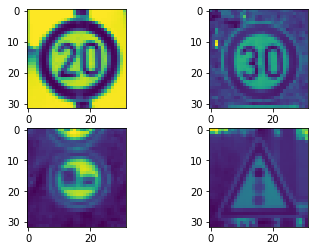

In [ ]:

fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(images[100, :, :].reshape(32,32) )
axes[0,1].imshow(images[1000, :, :].reshape(32,32) )
axes[1,0].imshow(images[16000, :, :].reshape(32,32) )
axes[1,1].imshow(images[30000, :, :].reshape(32,32))
print(image_labels[100, :])
print(image_labels[1000, :])
print(image_labels[16000, :])
print(image_labels[30000, :])

Разобъем данные на тестовое, учебное и валидационное множества

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(images, image_labels,test_size=0.2)

Определим функцию вывода графиков зависимости функции потерь от эпохи

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

def plotMetricsDependency(train_X,train_Y,test_X,test_Y,model, 
                          callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=0)):
  history=model.fit(train_X,train_Y,epochs=10,batch_size=20,callbacks=callback,
                    validation_data=(test_X, test_Y),verbose=1)
  num_epochs = np.arange(0, len(history.history['accuracy']))
  plt.figure(dpi=200)

  plt.plot(num_epochs, history.history['accuracy'], label='train_acc', c='green')
  plt.plot(num_epochs, history.history['val_loss'], label='val_loss', c='orange')
  plt.plot(num_epochs, history.history['val_accuracy'], label='val_acc', c='blue')
  plt.plot(num_epochs, history.history['loss'], label='train_loss', c='red')
  plt.title('Training Loss and Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss/Accuracy')
  plt.legend()

Определим функцию создания модели

In [ ]:
input_shape = (32, 32,1)

def modelBuilder( filters=32, kernel_size=(3,3), strides = (1,1), padding='valid',
    isBatchNorm=False,isDropOut=False, isMaxPooling=False,isAveragePooling=False,
    rate=0.2):
  
    model = tf.keras.Sequential(
        
         [tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides = strides,
            padding=padding,
            activation=tf.keras.activations.elu,
            kernel_initializer=tf.keras.initializers.HeNormal,
            input_shape=input_shape
        )] + \
        ([tf.keras.layers.MaxPool2D(pool_size=(2,2))] if isMaxPooling else []) + \
        ([tf.keras.layers.AveragePooling2D(pool_size=(2,2))] if isAveragePooling else []) + \
        ([tf.keras.layers.BatchNormalization(axis=-1)] if isBatchNorm else []) + \
        ([tf.keras.layers.Dropout(rate)] if isDropOut else []) +\


        [tf.keras.layers.Conv2D(
             filters=filters,
            kernel_size=kernel_size,
            strides = strides,
            padding=padding,
            kernel_initializer=tf.keras.initializers.HeNormal,
            activation=tf.keras.activations.elu,
        )] + \
        ([tf.keras.layers.MaxPool2D(pool_size=(2,2))] if isMaxPooling else []) + \
        ([tf.keras.layers.AveragePooling2D(pool_size=(2,2))] if isAveragePooling else []) + \
        ([tf.keras.layers.BatchNormalization(axis=-1)] if isBatchNorm else []) + \
        ([tf.keras.layers.Dropout(rate)] if isDropOut else []) +\


        [tf.keras.layers.Flatten()] + \
        [tf.keras.layers.Dense(num_classes,activation=tf.keras.activations.softmax)]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss= 'categorical_crossentropy',
        metrics=["accuracy"]
    )
    return model

Обучим стандартную модель и проверим ее качество 

Epoch 1/10
1569/1569 [==============================] - 13s 8ms/step - loss: 1.6600 - accuracy: 0.6805 - val_loss: 0.5362 - val_accuracy: 0.8866
Epoch 2/10
1569/1569 [==============================] - 12s 8ms/step - loss: 0.4281 - accuracy: 0.9061 - val_loss: 0.4133 - val_accuracy: 0.9149
Epoch 3/10
1569/1569 [==============================] - 12s 8ms/step - loss: 0.2603 - accuracy: 0.9381 - val_loss: 0.4679 - val_accuracy: 0.9185
Epoch 4/10
1569/1569 [==============================] - 12s 8ms/step - loss: 0.2376 - accuracy: 0.9451 - val_loss: 0.4234 - val_accuracy: 0.9276
Epoch 5/10
1569/1569 [==============================] - 12s 8ms/step - loss: 0.1832 - accuracy: 0.9582 - val_loss: 0.4391 - val_accuracy: 0.9319
Epoch 6/10
1569/1569 [==============================] - 12s 8ms/step - loss: 0.1804 - accuracy: 0.9587 - val_loss: 0.4592 - val_accuracy: 0.9345
Epoch 7/10
1569/1569 [==============================] - 12s 8ms/step - loss: 0.1292 - accuracy: 0.9706 - val_loss: 0.5272 - val_ac

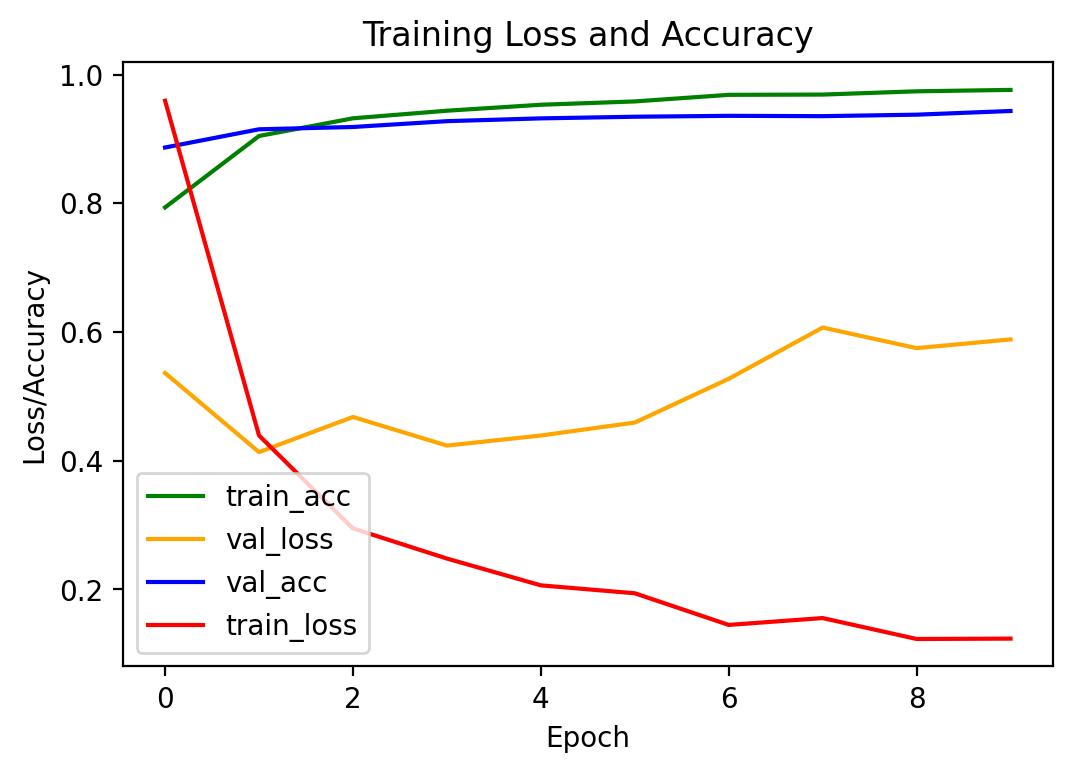

In [ ]:
base_model=modelBuilder()
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Попробуем поменять количество фильтров . Установим количество фильтров равным 64

Epoch 1/10
1569/1569 [==============================] - 15s 9ms/step - loss: 1.8598 - accuracy: 0.5199 - val_loss: 0.6161 - val_accuracy: 0.8525
Epoch 2/10
1569/1569 [==============================] - 14s 9ms/step - loss: 0.4831 - accuracy: 0.8925 - val_loss: 0.5176 - val_accuracy: 0.8804
Epoch 3/10
1569/1569 [==============================] - 14s 9ms/step - loss: 0.3719 - accuracy: 0.9129 - val_loss: 0.5315 - val_accuracy: 0.8820
Epoch 4/10
1569/1569 [==============================] - 14s 9ms/step - loss: 0.3280 - accuracy: 0.9240 - val_loss: 0.4621 - val_accuracy: 0.9081
Epoch 5/10
1569/1569 [==============================] - 14s 9ms/step - loss: 0.3144 - accuracy: 0.9288 - val_loss: 0.4911 - val_accuracy: 0.8984
Epoch 6/10
1569/1569 [==============================] - 14s 9ms/step - loss: 0.2641 - accuracy: 0.9387 - val_loss: 0.4862 - val_accuracy: 0.9049
Epoch 7/10
1569/1569 [==============================] - 14s 9ms/step - loss: 0.2594 - accuracy: 0.9394 - val_loss: 0.5079 - val_ac

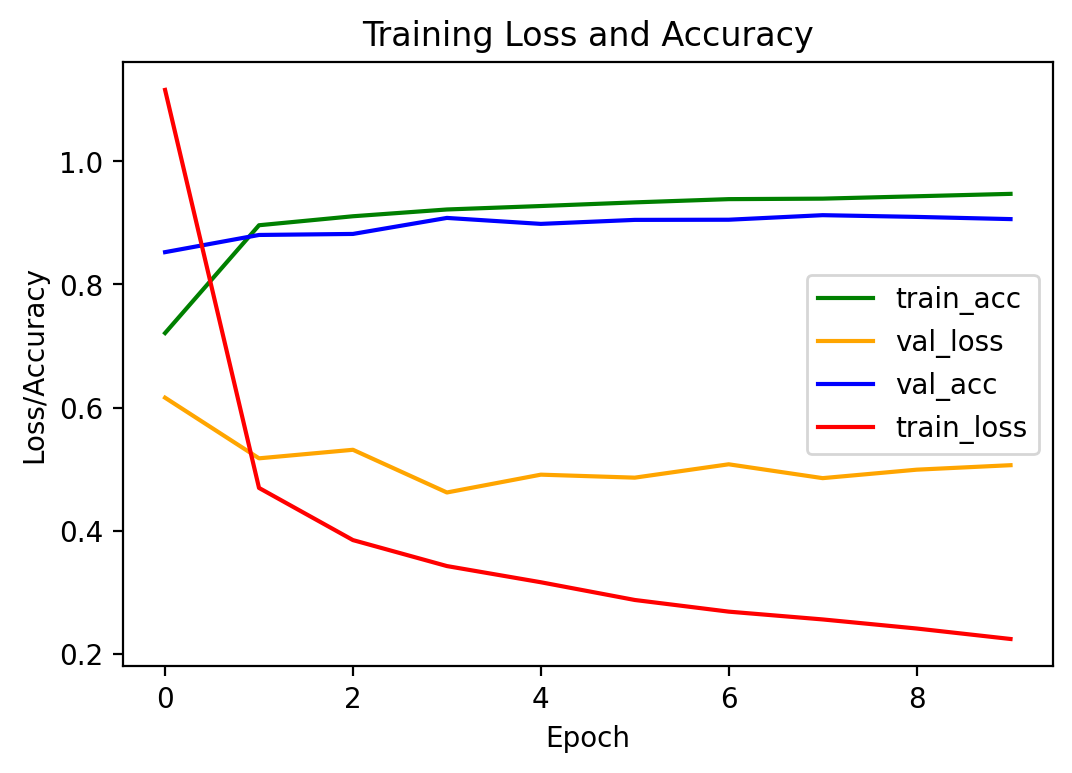

In [ ]:
base_model=modelBuilder(filters=64)
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Видим, что результат немного ухудшился, потому оставим количество фильтров равным 32 и изменим размер окна на (2,2)

Epoch 1/10
1569/1569 [==============================] - 12s 7ms/step - loss: 2.3934 - accuracy: 0.3714 - val_loss: 0.9919 - val_accuracy: 0.7441
Epoch 2/10
1569/1569 [==============================] - 11s 7ms/step - loss: 0.8440 - accuracy: 0.7840 - val_loss: 0.6469 - val_accuracy: 0.8437
Epoch 3/10
1569/1569 [==============================] - 11s 7ms/step - loss: 0.5741 - accuracy: 0.8615 - val_loss: 0.5641 - val_accuracy: 0.8715
Epoch 4/10
1569/1569 [==============================] - 11s 7ms/step - loss: 0.4241 - accuracy: 0.8989 - val_loss: 0.4880 - val_accuracy: 0.8953
Epoch 5/10
1569/1569 [==============================] - 11s 7ms/step - loss: 0.3395 - accuracy: 0.9213 - val_loss: 0.4365 - val_accuracy: 0.9042
Epoch 6/10
1569/1569 [==============================] - 11s 7ms/step - loss: 0.2859 - accuracy: 0.9345 - val_loss: 0.4510 - val_accuracy: 0.9075
Epoch 7/10
1569/1569 [==============================] - 11s 7ms/step - loss: 0.2418 - accuracy: 0.9432 - val_loss: 0.4662 - val_ac

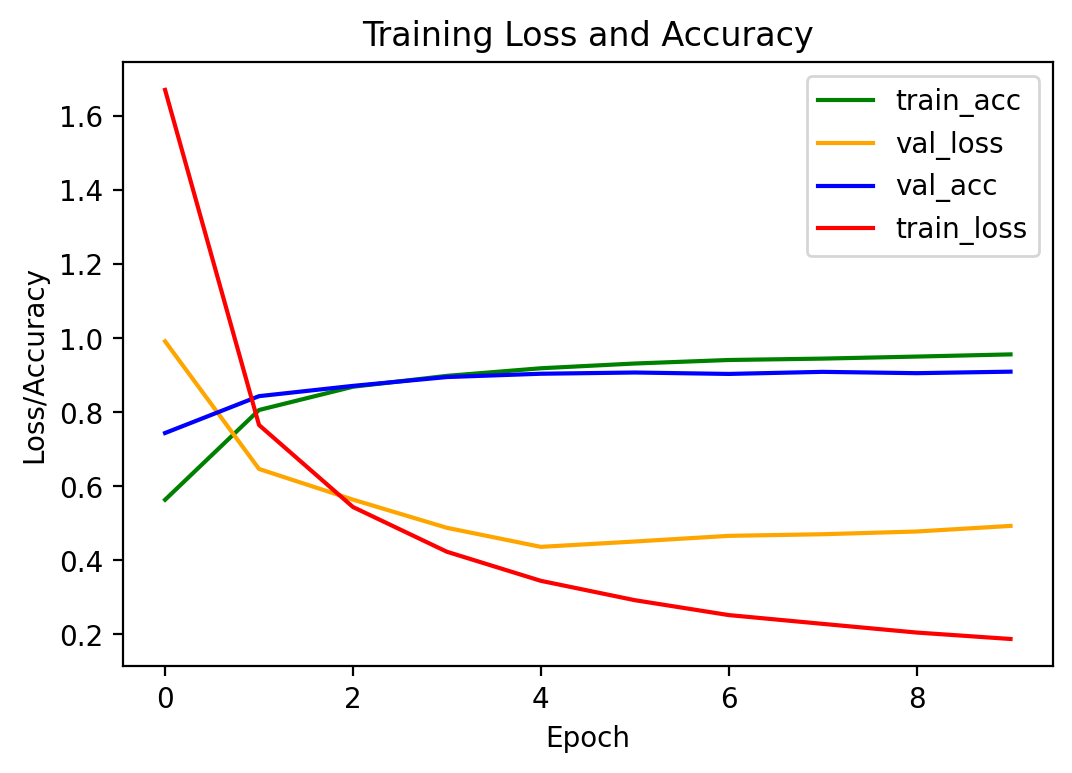

In [ ]:
base_model=modelBuilder(kernel_size=(2,2))
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Видим, что самая первая стандартная модель пока что самая лучшая, потому продолжаем работать с ней. Попробуем изменить размерность страйдов на (2,2)

Epoch 1/10
1569/1569 [==============================] - 8s 5ms/step - loss: 3.1342 - accuracy: 0.1674 - val_loss: 1.2613 - val_accuracy: 0.6793
Epoch 2/10
1569/1569 [==============================] - 7s 4ms/step - loss: 1.0307 - accuracy: 0.7296 - val_loss: 0.6151 - val_accuracy: 0.8416
Epoch 3/10
1569/1569 [==============================] - 7s 4ms/step - loss: 0.5137 - accuracy: 0.8698 - val_loss: 0.4387 - val_accuracy: 0.8868
Epoch 4/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.3582 - accuracy: 0.9140 - val_loss: 0.3654 - val_accuracy: 0.9107
Epoch 5/10
1569/1569 [==============================] - 7s 4ms/step - loss: 0.2821 - accuracy: 0.9350 - val_loss: 0.3251 - val_accuracy: 0.9230
Epoch 6/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.2329 - accuracy: 0.9446 - val_loss: 0.2885 - val_accuracy: 0.9295
Epoch 7/10
1569/1569 [==============================] - 7s 4ms/step - loss: 0.1878 - accuracy: 0.9558 - val_loss: 0.2642 - val_accuracy:

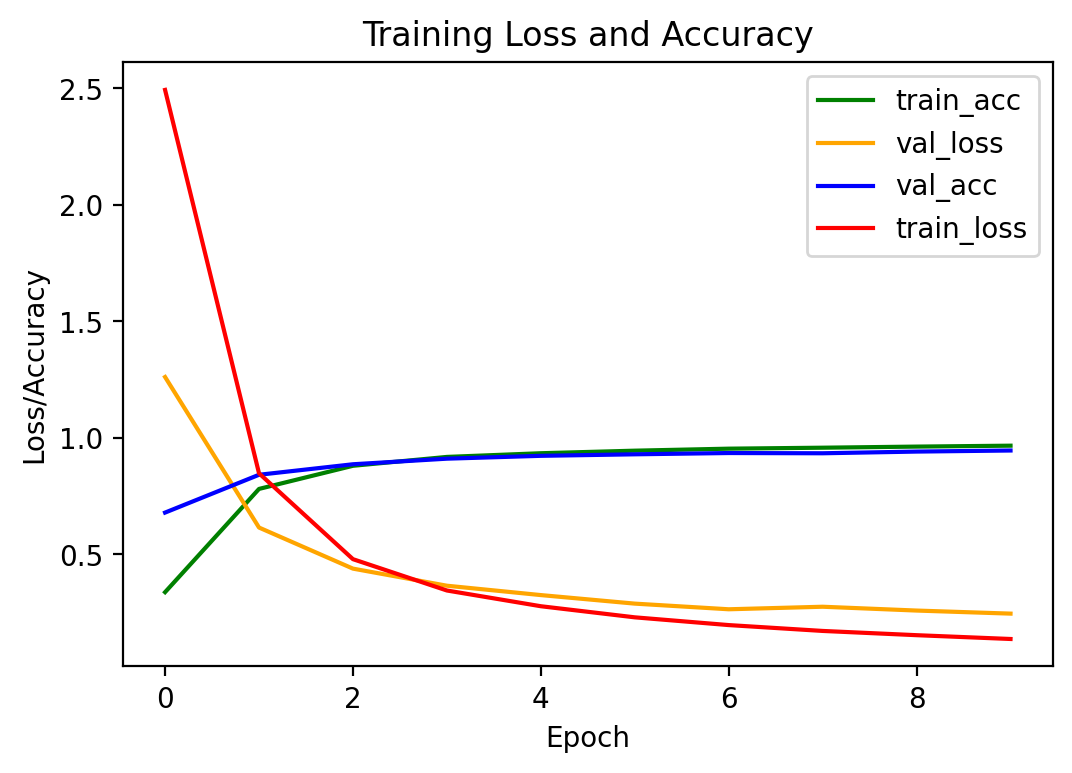

In [ ]:
base_model=modelBuilder(strides=(2,2))
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Результат явно улучшился, потому попробуем задать размер страйдов равным (3,3)

Epoch 1/10
1569/1569 [==============================] - 8s 5ms/step - loss: 3.4455 - accuracy: 0.0815 - val_loss: 2.5866 - val_accuracy: 0.3387
Epoch 2/10
1569/1569 [==============================] - 7s 4ms/step - loss: 2.0782 - accuracy: 0.4558 - val_loss: 1.2929 - val_accuracy: 0.6595
Epoch 3/10
1569/1569 [==============================] - 8s 5ms/step - loss: 1.1449 - accuracy: 0.6894 - val_loss: 0.9303 - val_accuracy: 0.7521
Epoch 4/10
1569/1569 [==============================] - 7s 4ms/step - loss: 0.8360 - accuracy: 0.7747 - val_loss: 0.7744 - val_accuracy: 0.7888
Epoch 5/10
1569/1569 [==============================] - 7s 4ms/step - loss: 0.6772 - accuracy: 0.8178 - val_loss: 0.6482 - val_accuracy: 0.8327
Epoch 6/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.5753 - accuracy: 0.8449 - val_loss: 0.5853 - val_accuracy: 0.8475
Epoch 7/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.4934 - accuracy: 0.8725 - val_loss: 0.5364 - val_accuracy:

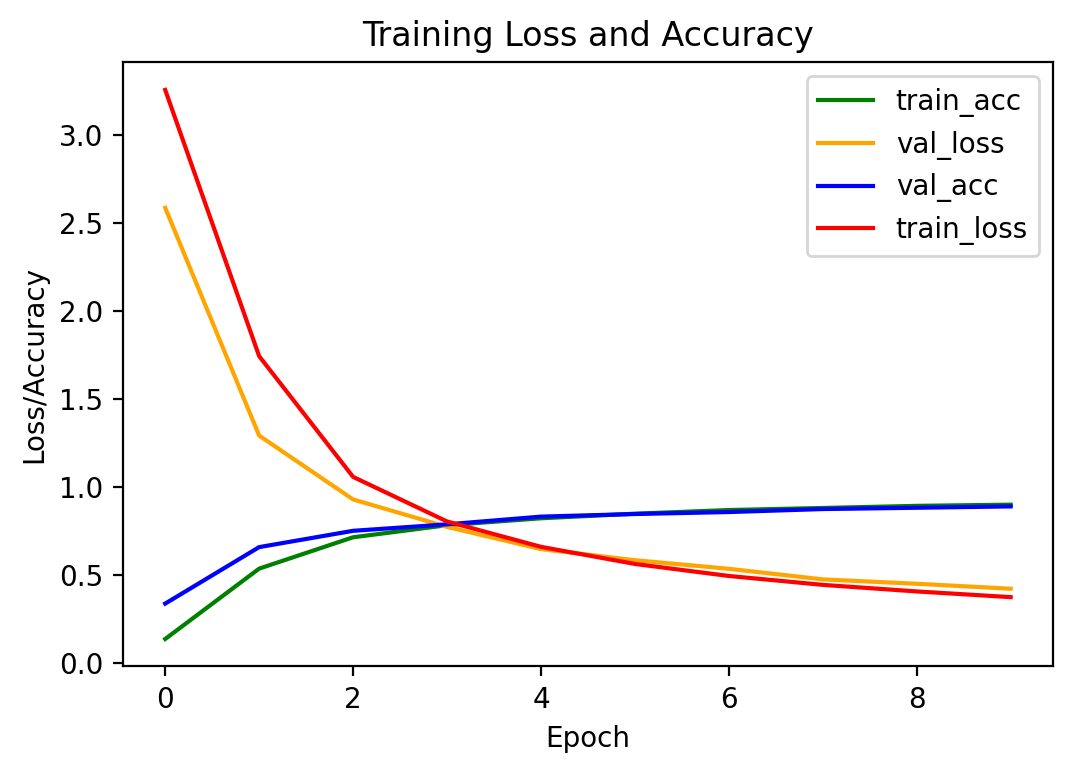

In [ ]:
base_model=modelBuilder(strides=(3,3))
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Результат стал хуже, потому далее будем работать со страйдами равными (2,2).Добавим в модель нормализацию и проверим ее качества

Epoch 1/10
1569/1569 [==============================] - 9s 5ms/step - loss: 1.3955 - accuracy: 0.6610 - val_loss: 1.3024 - val_accuracy: 0.6784
Epoch 2/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.4483 - accuracy: 0.8982 - val_loss: 0.6256 - val_accuracy: 0.8508
Epoch 3/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.3727 - accuracy: 0.9141 - val_loss: 0.7388 - val_accuracy: 0.8099
Epoch 4/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.3092 - accuracy: 0.9314 - val_loss: 1.2930 - val_accuracy: 0.7409
Epoch 5/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2589 - accuracy: 0.9416 - val_loss: 2.5000 - val_accuracy: 0.6327
Epoch 6/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2226 - accuracy: 0.9495 - val_loss: 0.6074 - val_accuracy: 0.8634
Epoch 7/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.1821 - accuracy: 0.9582 - val_loss: 0.6676 - val_accuracy:

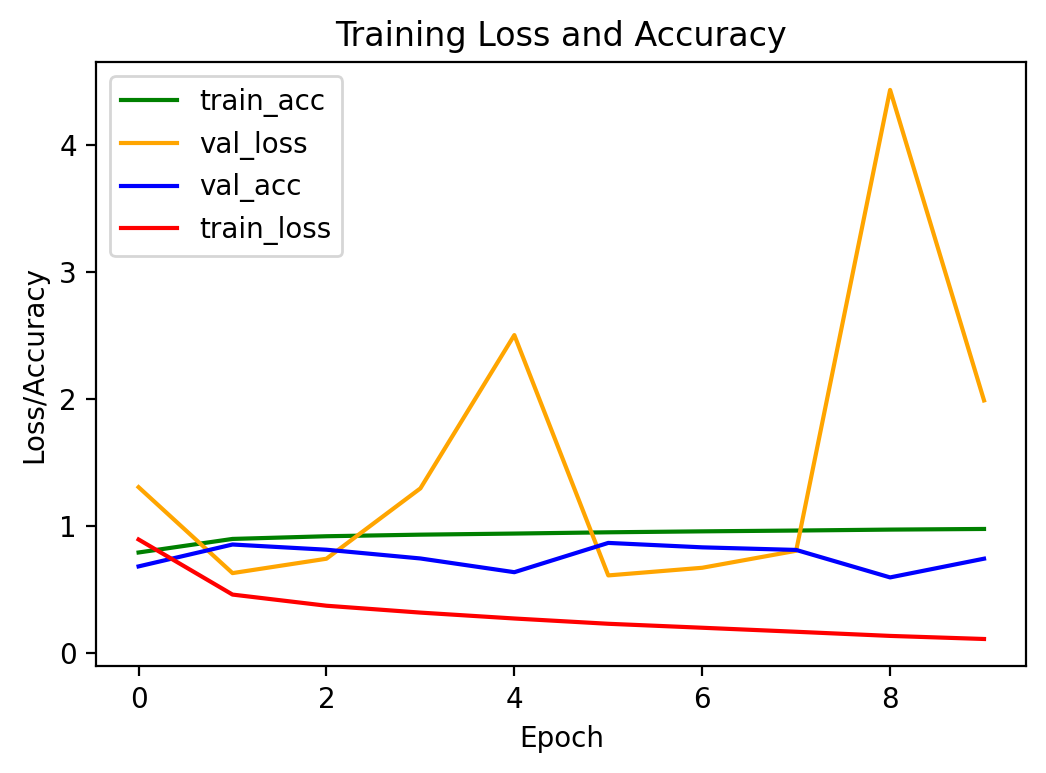

In [ ]:
base_model=modelBuilder(strides=(2,2), isBatchNorm = True)
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Нормализация ухудшила качество модели, потому вместо нее попробуем дропаут со стандартной вероятностью 0.2

Epoch 1/10
1569/1569 [==============================] - 8s 5ms/step - loss: 3.2155 - accuracy: 0.1470 - val_loss: 1.4149 - val_accuracy: 0.6154
Epoch 2/10
1569/1569 [==============================] - 7s 5ms/step - loss: 1.1798 - accuracy: 0.6823 - val_loss: 0.6941 - val_accuracy: 0.8249
Epoch 3/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.6926 - accuracy: 0.8184 - val_loss: 0.5134 - val_accuracy: 0.8775
Epoch 4/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.5487 - accuracy: 0.8551 - val_loss: 0.4053 - val_accuracy: 0.9091
Epoch 5/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.4690 - accuracy: 0.8772 - val_loss: 0.3609 - val_accuracy: 0.9176
Epoch 6/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.4153 - accuracy: 0.8879 - val_loss: 0.3362 - val_accuracy: 0.9199
Epoch 7/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.3951 - accuracy: 0.8958 - val_loss: 0.2948 - val_accuracy:

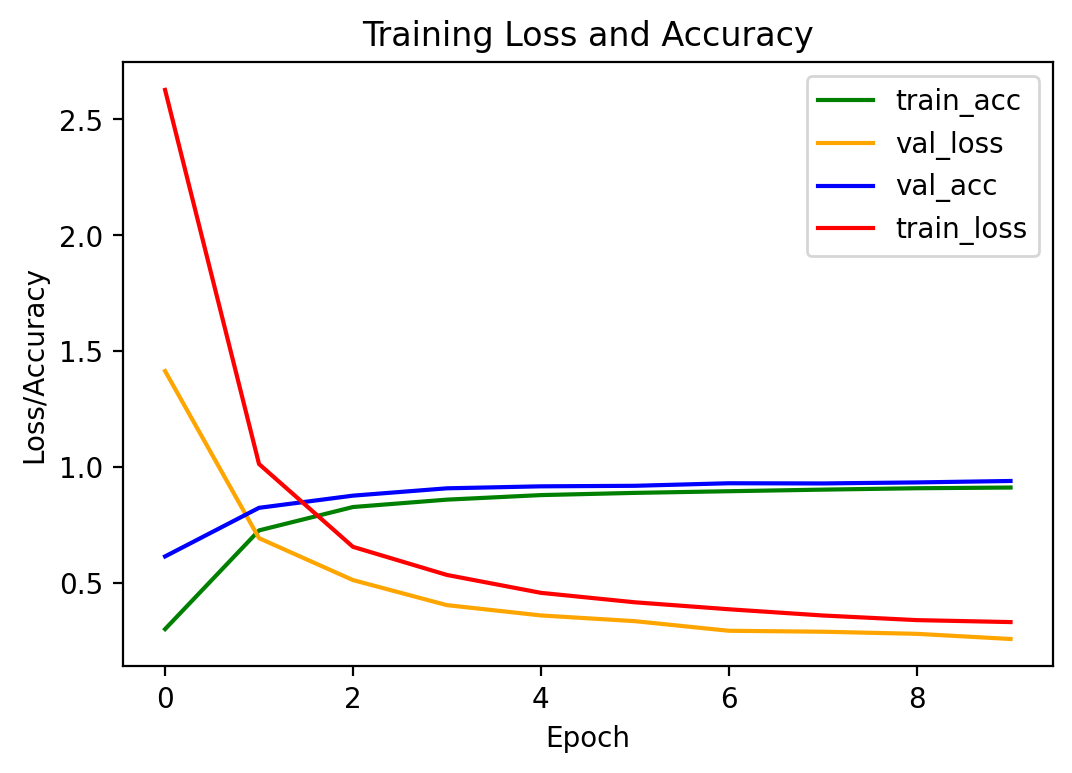

In [ ]:
base_model=modelBuilder(strides=(2,2), isDropOut = True)
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Изменим вероятность на 0.5, 0.01 и 0.1 и проверим качество модели

Epoch 1/10
1569/1569 [==============================] - 8s 5ms/step - loss: 3.3239 - accuracy: 0.1142 - val_loss: 1.6996 - val_accuracy: 0.5493
Epoch 2/10
1569/1569 [==============================] - 7s 5ms/step - loss: 1.5684 - accuracy: 0.5704 - val_loss: 0.8964 - val_accuracy: 0.7901
Epoch 3/10
1569/1569 [==============================] - 7s 5ms/step - loss: 1.0570 - accuracy: 0.7097 - val_loss: 0.7064 - val_accuracy: 0.8368
Epoch 4/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.9027 - accuracy: 0.7517 - val_loss: 0.6017 - val_accuracy: 0.8628
Epoch 5/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.8413 - accuracy: 0.7738 - val_loss: 0.5415 - val_accuracy: 0.8703
Epoch 6/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.7872 - accuracy: 0.7831 - val_loss: 0.4968 - val_accuracy: 0.8875
Epoch 7/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.7342 - accuracy: 0.7994 - val_loss: 0.4710 - val_accuracy:

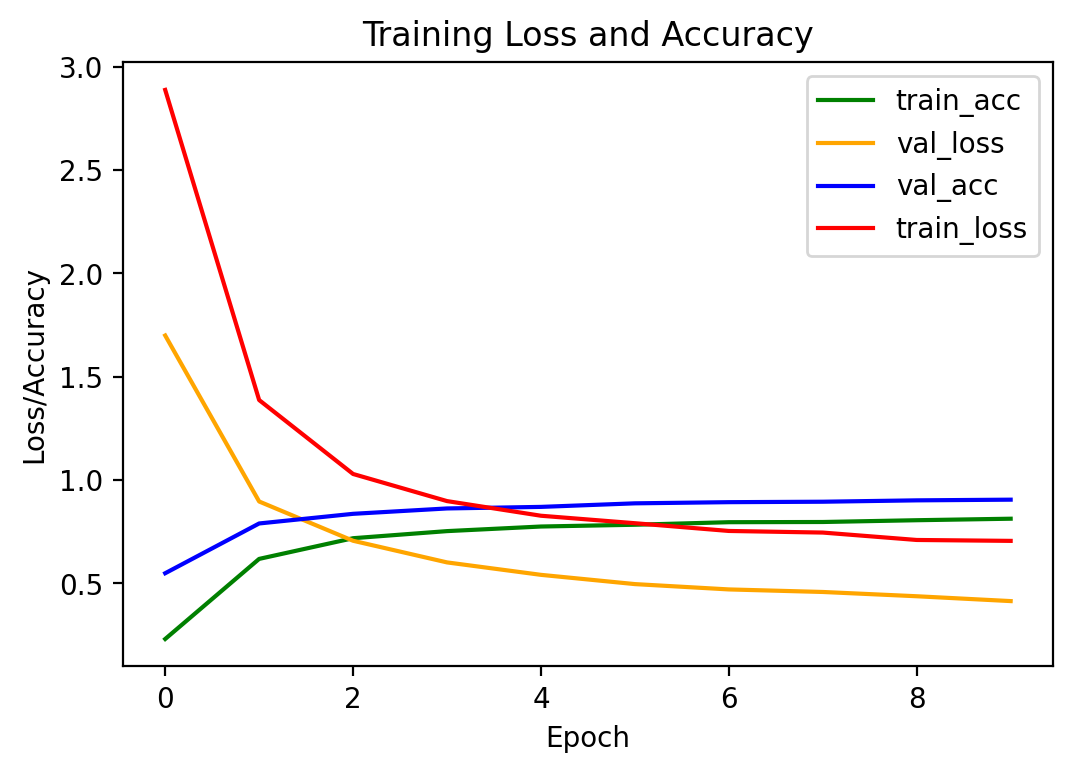

In [ ]:
base_model=modelBuilder(strides=(2,2), rate=0.5,isDropOut = True)
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Epoch 1/10
1569/1569 [==============================] - 8s 5ms/step - loss: 3.1452 - accuracy: 0.1613 - val_loss: 1.2401 - val_accuracy: 0.6844
Epoch 2/10
1569/1569 [==============================] - 8s 5ms/step - loss: 1.0341 - accuracy: 0.7299 - val_loss: 0.6599 - val_accuracy: 0.8370
Epoch 3/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.6099 - accuracy: 0.8447 - val_loss: 0.4560 - val_accuracy: 0.8925
Epoch 4/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.4362 - accuracy: 0.8897 - val_loss: 0.3761 - val_accuracy: 0.9114
Epoch 5/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.3708 - accuracy: 0.9083 - val_loss: 0.3210 - val_accuracy: 0.9211
Epoch 6/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.3050 - accuracy: 0.9192 - val_loss: 0.2971 - val_accuracy: 0.9310
Epoch 7/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2805 - accuracy: 0.9278 - val_loss: 0.2785 - val_accuracy:

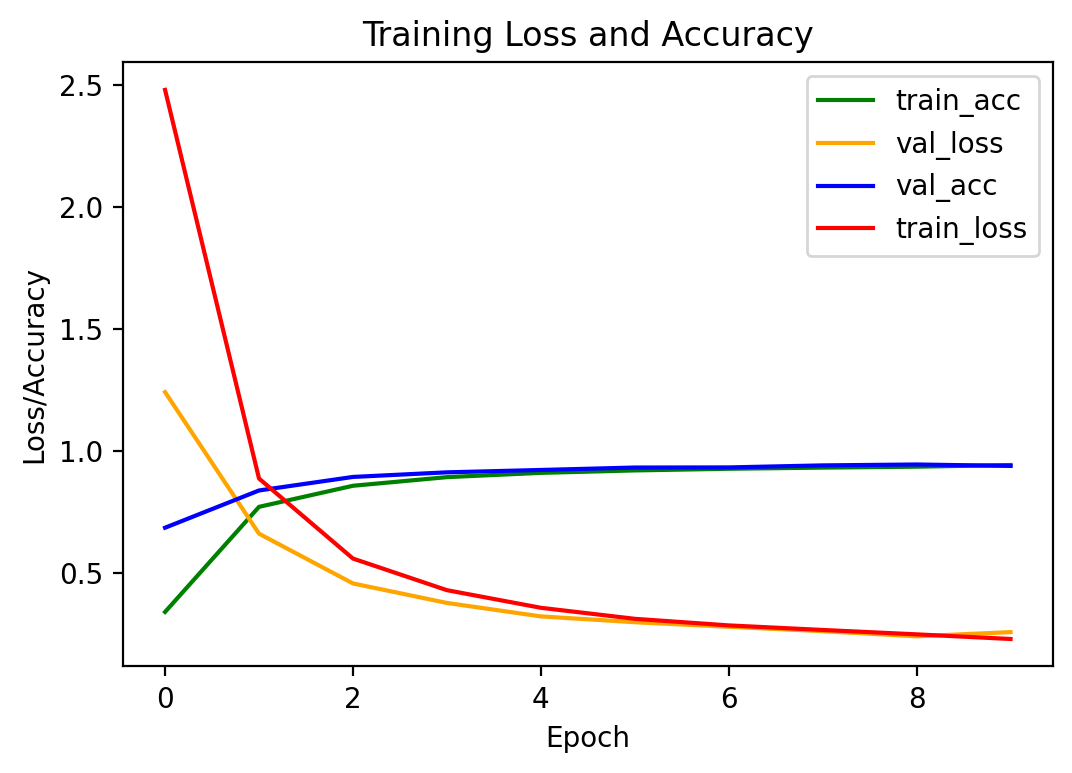

In [ ]:
base_model=modelBuilder(strides=(2,2), rate=0.1,isDropOut = True)
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Epoch 1/10
1569/1569 [==============================] - 8s 5ms/step - loss: 3.1676 - accuracy: 0.1554 - val_loss: 1.3062 - val_accuracy: 0.6404
Epoch 2/10
1569/1569 [==============================] - 8s 5ms/step - loss: 1.0330 - accuracy: 0.7316 - val_loss: 0.6072 - val_accuracy: 0.8535
Epoch 3/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.5310 - accuracy: 0.8665 - val_loss: 0.4413 - val_accuracy: 0.8908
Epoch 4/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.3732 - accuracy: 0.9096 - val_loss: 0.3579 - val_accuracy: 0.9126
Epoch 5/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2852 - accuracy: 0.9293 - val_loss: 0.3089 - val_accuracy: 0.9253
Epoch 6/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2483 - accuracy: 0.9397 - val_loss: 0.3018 - val_accuracy: 0.9255
Epoch 7/10
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2061 - accuracy: 0.9487 - val_loss: 0.2661 - val_accuracy:

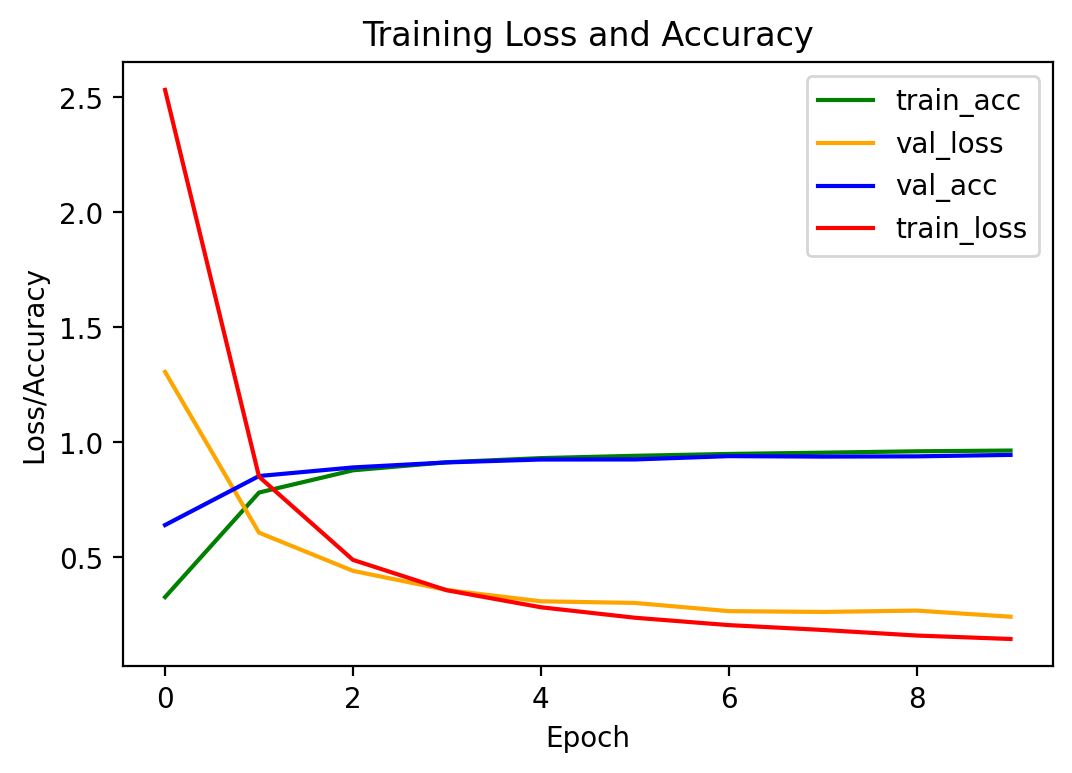

In [ ]:
base_model=modelBuilder(strides=(2,2), rate=0.01,isDropOut = True)
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Видим, что без дропаута модель работает немного лучше, потому попробуем добавить макспулинг

Epoch 1/10
1569/1569 [==============================] - 8s 5ms/step - loss: 3.5289 - accuracy: 0.0558 - val_loss: 3.4656 - val_accuracy: 0.0954
Epoch 2/10
1569/1569 [==============================] - 7s 5ms/step - loss: 3.4359 - accuracy: 0.0836 - val_loss: 3.3635 - val_accuracy: 0.0982
Epoch 3/10
1569/1569 [==============================] - 7s 5ms/step - loss: 3.3528 - accuracy: 0.1075 - val_loss: 3.2621 - val_accuracy: 0.1246
Epoch 4/10
1569/1569 [==============================] - 7s 5ms/step - loss: 3.2028 - accuracy: 0.1428 - val_loss: 3.0419 - val_accuracy: 0.1728
Epoch 5/10
1569/1569 [==============================] - 7s 5ms/step - loss: 2.9843 - accuracy: 0.1909 - val_loss: 2.8111 - val_accuracy: 0.2422
Epoch 6/10
1569/1569 [==============================] - 7s 5ms/step - loss: 2.7311 - accuracy: 0.2575 - val_loss: 2.5857 - val_accuracy: 0.2979
Epoch 7/10
1569/1569 [==============================] - 7s 5ms/step - loss: 2.5282 - accuracy: 0.3187 - val_loss: 2.4250 - val_accuracy:

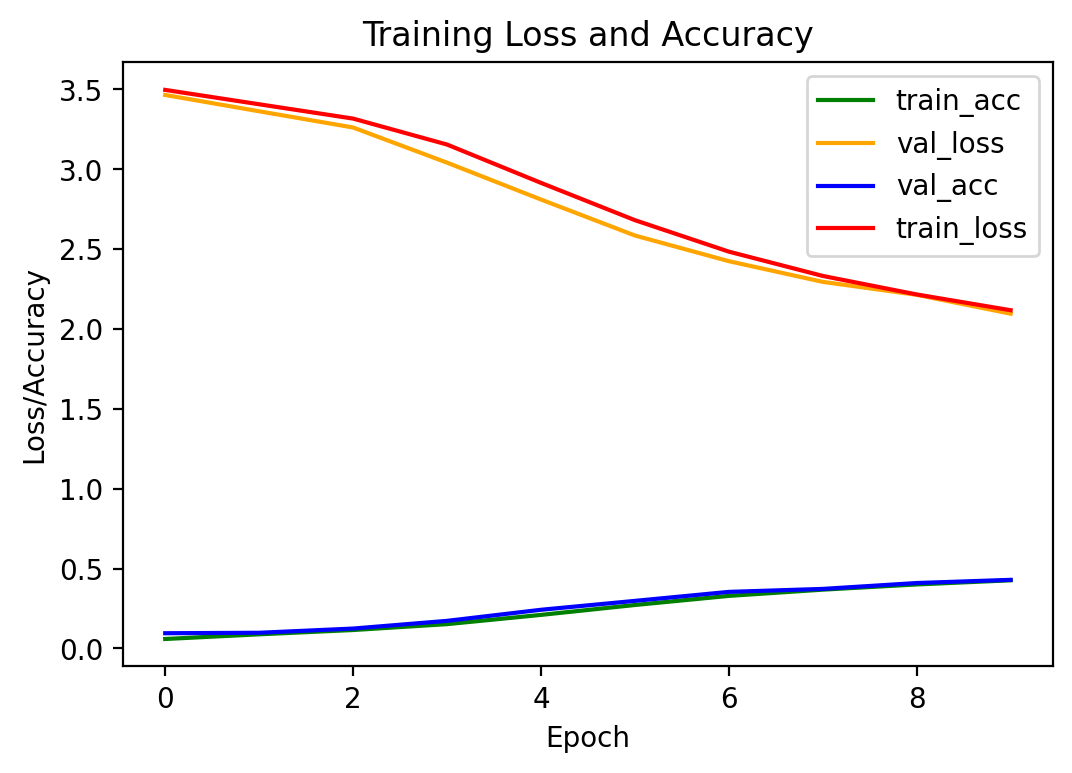

In [ ]:
base_model=modelBuilder(strides=(2,2), isMaxPooling=True)
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Макспулинг значительно ухудшил модель, потому попробуем пулинг по среднему значению

Epoch 1/10
1569/1569 [==============================] - 8s 5ms/step - loss: 3.5292 - accuracy: 0.0557 - val_loss: 3.4687 - val_accuracy: 0.0565
Epoch 2/10
1569/1569 [==============================] - 7s 5ms/step - loss: 3.4394 - accuracy: 0.0807 - val_loss: 3.3878 - val_accuracy: 0.0871
Epoch 3/10
1569/1569 [==============================] - 7s 5ms/step - loss: 3.3827 - accuracy: 0.0897 - val_loss: 3.3550 - val_accuracy: 0.1021
Epoch 4/10
1569/1569 [==============================] - 7s 5ms/step - loss: 3.3500 - accuracy: 0.0976 - val_loss: 3.3102 - val_accuracy: 0.1106
Epoch 5/10
1569/1569 [==============================] - 7s 5ms/step - loss: 3.2956 - accuracy: 0.1141 - val_loss: 3.2585 - val_accuracy: 0.1214
Epoch 6/10
1569/1569 [==============================] - 7s 5ms/step - loss: 3.2295 - accuracy: 0.1246 - val_loss: 3.1796 - val_accuracy: 0.1390
Epoch 7/10
1569/1569 [==============================] - 7s 5ms/step - loss: 3.1597 - accuracy: 0.1404 - val_loss: 3.1276 - val_accuracy:

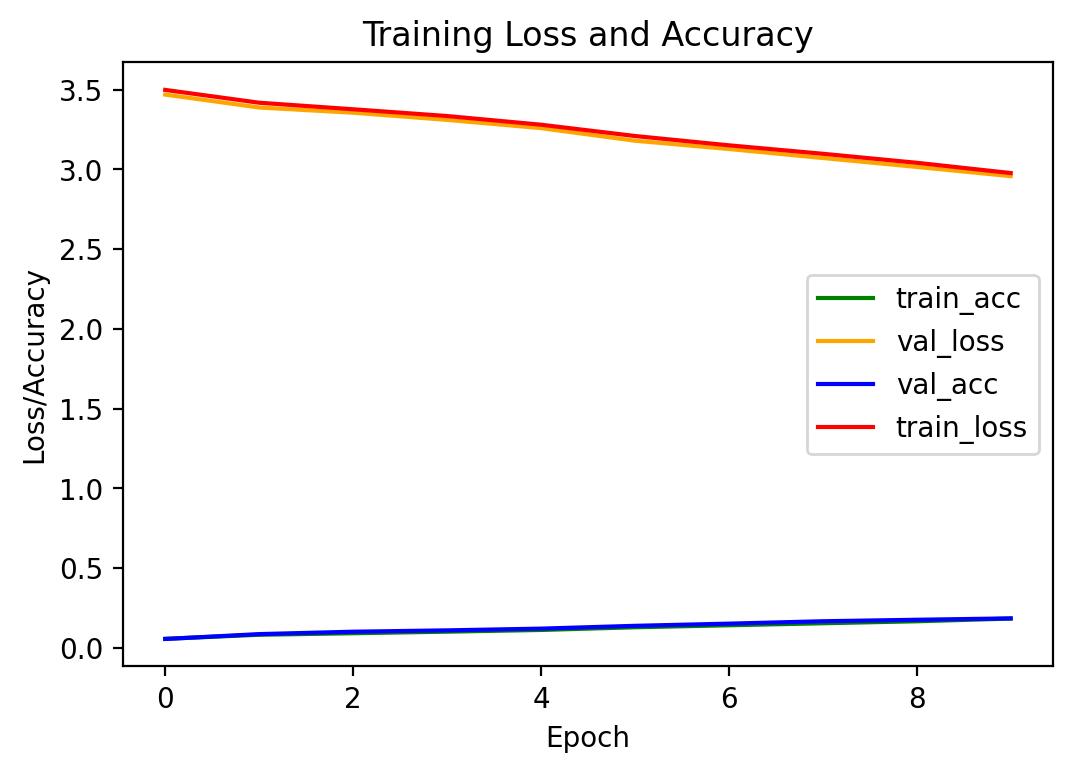

In [ ]:
base_model=modelBuilder(strides=(2,2), isAveragePooling=True)
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Попробуем использовать другой тип паддинга

Epoch 1/10
1569/1569 [==============================] - 8s 5ms/step - loss: 3.1295 - accuracy: 0.1689 - val_loss: 1.2493 - val_accuracy: 0.6616
Epoch 2/10
1569/1569 [==============================] - 7s 5ms/step - loss: 1.0047 - accuracy: 0.7364 - val_loss: 0.6494 - val_accuracy: 0.8321
Epoch 3/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.5479 - accuracy: 0.8641 - val_loss: 0.4692 - val_accuracy: 0.8861
Epoch 4/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.3744 - accuracy: 0.9064 - val_loss: 0.3686 - val_accuracy: 0.9158
Epoch 5/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.2987 - accuracy: 0.9271 - val_loss: 0.3282 - val_accuracy: 0.9271
Epoch 6/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.2494 - accuracy: 0.9395 - val_loss: 0.3320 - val_accuracy: 0.9200
Epoch 7/10
1569/1569 [==============================] - 7s 5ms/step - loss: 0.2181 - accuracy: 0.9489 - val_loss: 0.2866 - val_accuracy:

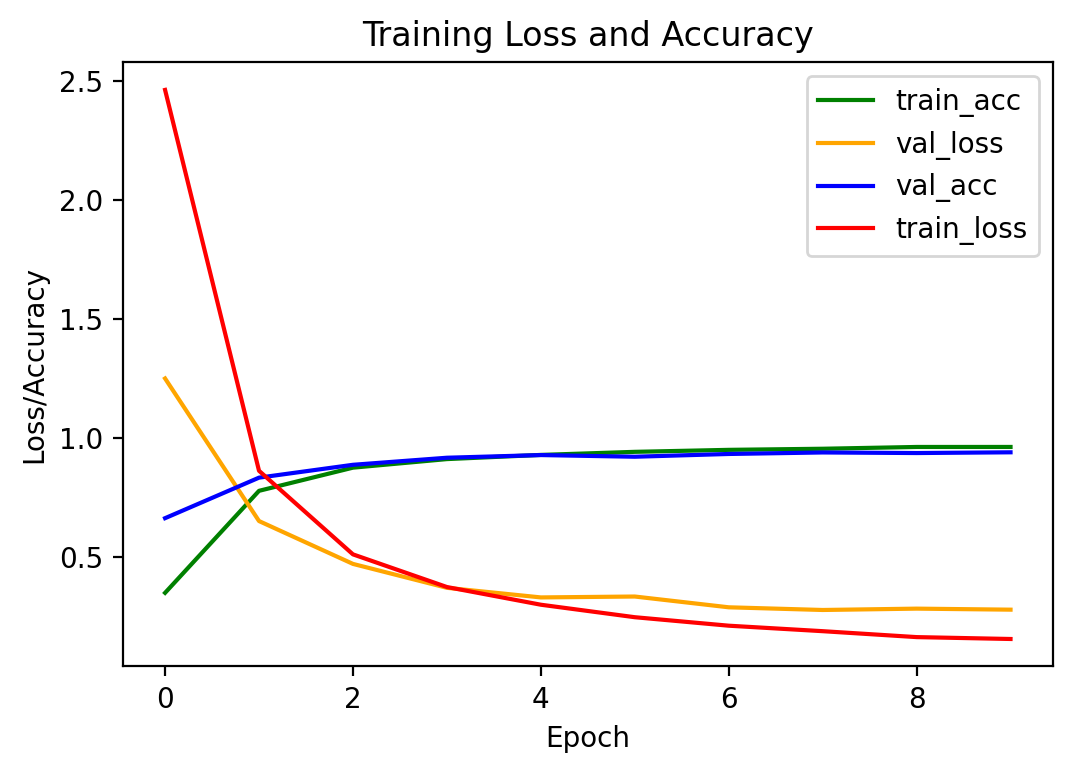

In [ ]:
base_model=modelBuilder(strides=(2,2), padding='same')
plotMetricsDependency(train_X,train_y,test_X,test_y,base_model)

Видим, что найлучшей пока что является стандартная модель без дополнительных слоев со страйдами размером (2,2). Используем эту модель дл классификации изображения

In [ ]:
base_model=modelBuilder(strides=(2,2))
base_model.fit(train_X,train_y,epochs=10,batch_size=20)


Epoch 1/10
1569/1569 [==============================] - 7s 4ms/step - loss: 3.1659 - accuracy: 0.1605
Epoch 2/10
1569/1569 [==============================] - 6s 4ms/step - loss: 1.0762 - accuracy: 0.7116
Epoch 3/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.5488 - accuracy: 0.8645
Epoch 4/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.3746 - accuracy: 0.9094
Epoch 5/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.2822 - accuracy: 0.9317
Epoch 6/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.2263 - accuracy: 0.9466
Epoch 7/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.1875 - accuracy: 0.9531
Epoch 8/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.1682 - accuracy: 0.9612
Epoch 9/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.1509 - accuracy: 0.9632
Epoch 10/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.125

In [ ]:
train_loss, train_acc = base_model.evaluate(train_X, train_y, verbose=0)
test_loss, test_acc = base_model.evaluate(test_X, test_y, verbose=0)


print(f"TRAIN loss, acc = {train_loss}, {train_acc}\nTEST loss, acc = {test_loss}, {test_acc}")

TRAIN loss, acc = 0.1027284562587738, 0.9760257601737976
TEST loss, acc = 0.23076264560222626, 0.9491201043128967


In [ ]:
y_pred=base_model.predict(test_X)
lower_value=0.5
y_pred[y_pred<lower_value]=0
print(y_pred[1])
print(test_y[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


Теперь поработаем с уже обученной сетью. Для начала изменим наш набор данных для работы с новой сетью

In [ ]:
num_classes= 15
data_path = 'GTSRB/Final_Training/Images'
images_list = []
image_labels = []
for i in range(num_classes):
    image_path = data_path + '/' + format(i, '05d') + '/'
    for img in glob.glob(image_path + '*.ppm'):
        image = cv2.imread(img)
        image = resize(image, (299, 299))
        images_list.append(image)
       
        labels = np.zeros((num_classes, ), dtype=np.float32)
        labels[i] = 1.0
        image_labels.append(labels)
        if len(images_list)%100 == 0:
          break
images = np.asarray(images_list, dtype=np.dtype(np.float32))
image_labels = np.matrix(image_labels).astype(np.int32)

In [ ]:
print(images.shape)

(1500, 299, 299, 3)


[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]
[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]
[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


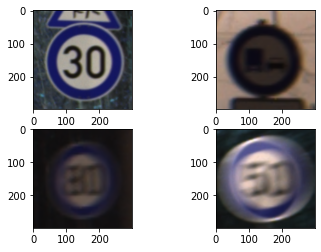

In [ ]:

fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(images[100, :, :] )
axes[0,1].imshow(images[1000, :, :] )
axes[1,0].imshow(images[500, :, :] )
axes[1,1].imshow(images[200, :, :])
print(image_labels[100, :])
print(image_labels[1000, :])
print(image_labels[500, :])
print(image_labels[200, :])


In [ ]:
train_X, test_X, train_y, test_y = train_test_split(images, image_labels,test_size=0.2)

Импортируем обученную сеть

In [ ]:
modelK = tf.keras.applications.InceptionV3(
    include_top=True, weights='imagenet', classes=1000,
    classifier_activation='softmax'
)

Выполним замену классов для этой сети

In [ ]:
predictionK_test = tf.keras.applications.inception_v3.decode_predictions(modelK.predict(test_X))

40960/35363 [==================================] - 0s 0us/step


In [ ]:
modelK = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', classes=1000,
    classifier_activation='softmax'
)
modelK.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
num_classes = 15
def modelBuilder():
    model = tf.keras.Sequential(
        [modelK] + \
        [tf.keras.layers.GlobalAveragePooling2D()] + \
        [tf.keras.layers.Dropout(0.5)] + \
        [tf.keras.layers.Dense(120, activation="relu")] + \
        [tf.keras.layers.Dropout(0.5)] + \
        [tf.keras.layers.Dense(num_classes)]

    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss= 'categorical_crossentropy',
        metrics=["accuracy"]
    )
    return model

In [ ]:
modelKT = modelBuilder()

Epoch 1/10
60/60 [==============================] - 24s 278ms/step - loss: 7.8461 - accuracy: 0.0691 - val_loss: 9.3593 - val_accuracy: 0.0533
Epoch 2/10
60/60 [==============================] - 15s 255ms/step - loss: 8.4210 - accuracy: 0.0659 - val_loss: 8.5464 - val_accuracy: 0.0533
Epoch 3/10
60/60 [==============================] - 15s 255ms/step - loss: 7.9132 - accuracy: 0.0711 - val_loss: 9.7523 - val_accuracy: 0.0767
Epoch 4/10
60/60 [==============================] - 15s 257ms/step - loss: 8.0104 - accuracy: 0.0690 - val_loss: 7.1877 - val_accuracy: 0.0533
Epoch 5/10
60/60 [==============================] - 15s 258ms/step - loss: 8.0479 - accuracy: 0.0847 - val_loss: 6.5596 - val_accuracy: 0.0667
Epoch 6/10
60/60 [==============================] - 16s 260ms/step - loss: 7.5959 - accuracy: 0.0582 - val_loss: 8.5318 - val_accuracy: 0.0567
Epoch 7/10
60/60 [==============================] - 16s 259ms/step - loss: 7.7460 - accuracy: 0.0630 - val_loss: 7.1275 - val_accuracy: 0.0767

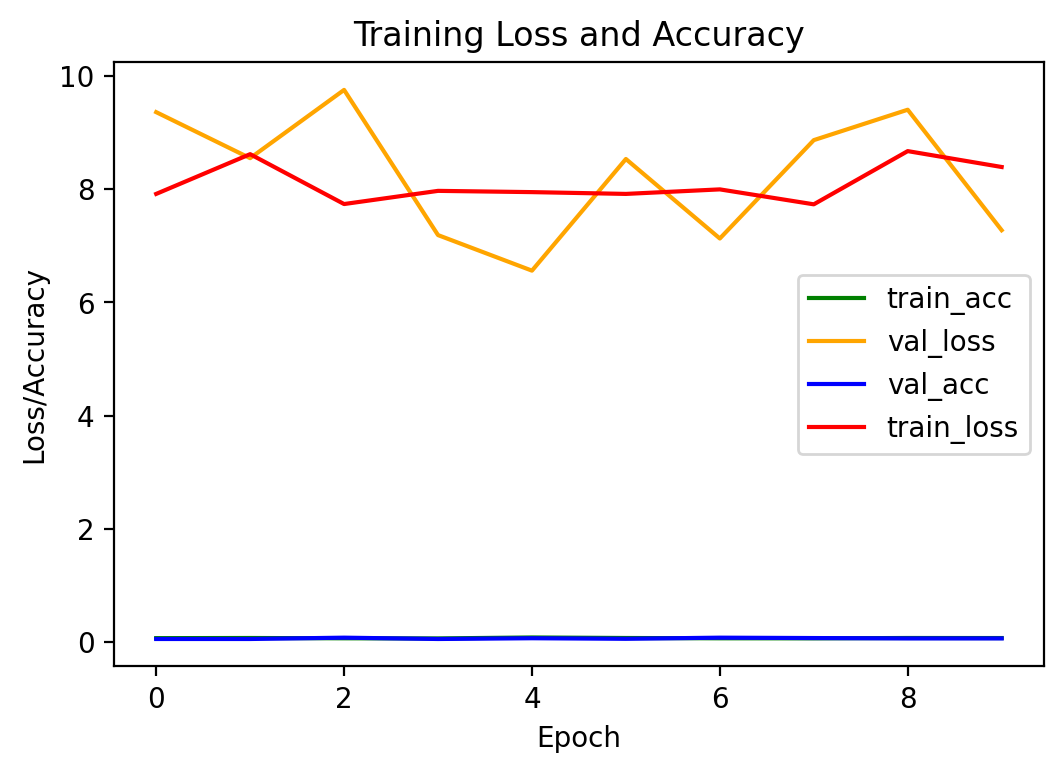

In [ ]:
plotMetricsDependency(train_X,train_y,test_X,test_y,modelKT)

In [ ]:
train_loss, train_acc = modelKT.evaluate(train_X, train_y, verbose=0)
test_loss, test_acc = modelKT.evaluate(test_X, test_y, verbose=0)

In [ ]:
print(f"TRAIN loss, acc = {train_loss}, {train_acc}\nTEST loss, acc = {test_loss}, {test_acc}")

TRAIN loss, acc = 7.845604419708252, 0.06833333522081375
TEST loss, acc = 7.273858070373535, 0.06333333253860474
